# **Workshop: From electrons to phase diagrams**

# Day 2: Validation of the potentials

Once we have the fitted potentials, it is necessary to validate them in order to assess their quality with respect to applications.

In this exercise, we use the fitted potentials and perform some basic calculations.

## Import the fitted potentials for Li-Al (from earlier excercise)

The same directory contains a `helper.py` file which among other things, also contains the necessary specifications of each of the potentials that we will use today. Individual potentials are descrbed in the LAMMPS format as:
```
pot_eam = pd.DataFrame({
    'Name': ['LiAl_eam'],
    'Filename': [["../potentials/AlLi.eam.fs")]],
    'Model': ["EAM"],
    'Species': [['Li', 'Al']],
    'Config': [['pair_style eam/fs\n', 'pair_coeff * * AlLi.eam.fs Li Al\n']]
})

```
A list of such DataFrames describing the potentials is saved in a list called `potentials_list`. We import the list as:

In [1]:
from helper import potentials_list

# potentials_list = [potentials_list[0],potentials_list[1]]

# display the first element in the list
# which is an EAM potential
potentials_list[2]

,Name,Filename,Model,Species,Config
0,LiAl_yace,[/home/jovyan/workshop_preparation/potentials/...,ACE,"[Al, Li]","[pair_style pace\n, pair_coeff * * AlLi-6gen-1..."


### Import other important modules

In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import time

from helper import get_clean_project_name

from pyiron_atomistics import Project
from pyiron import pyiron_to_ase
import pyiron_gpl

# save start time to record runtime of the notebook
time_start =  time.time()
time_start

1654697715.1585205

### Create a new project to perform validation calculations

It is useful to create a new project directory for every kind of calculation. Pyiron will automatically create subdirectories for each potential and property we calculate. 

In [3]:
pr = Project("validation_LiAl")

# remove earlier jobs
# pr.remove_jobs(silently=True, recursive=True)

### Define the important pases to consider for validation

We construct a python dictionary `struct_dict` which contains a description of all the important phases that we want to consider for this exercise. The descriptions given in the dictionary will be later used by Pyiron to generate or read the structural configurations for the respective phases.

For unary phases, we provide an initial guess for the lattice parameter and use pyiron to generate the structural prototype.

For binary phases, we provide a phase name and an additional dictionary `fl_dict` which maps the phase name to a `.cif` file saved in a subdirectory. Pyiron will use this information to read the respective configurations from the file.

In [4]:
struct_dict = dict()

# structures to be generated automatically
struct_dict["Al"] = dict()
struct_dict["Al"]["s_murn"] = ["fcc","bcc"]
struct_dict["Al"]["a"] = 4.04

struct_dict["Li"] = dict()
struct_dict["Li"]["s_murn"] = ["bcc","fcc"]
struct_dict["Li"]["a"] = 3.5


# structures to be read from file
struct_dict["Li2Al2"] = dict()
struct_dict["Li2Al2"]["s_murn"] = ["Li2Al2_cubic"]

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_tetragonal"]

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_cubic"]

struct_dict["Li9Al4"] = dict()
struct_dict["Li9Al4"]["s_murn"] = ["Li9Al4_monoclinic"]

struct_dict["Li3Al2"] = dict()
struct_dict["Li3Al2"]["s_murn"] = ["Li3Al2_trigonal"]

struct_dict["Li4Al4"] = dict()
struct_dict["Li4Al4"]["s_murn"] = ["Li4Al4_cubic"]

struct_dict

{'Al': {'s_murn': ['fcc', 'bcc'], 'a': 4.04},
 'Li': {'s_murn': ['bcc', 'fcc'], 'a': 3.5},
 'Li2Al2': {'s_murn': ['Li2Al2_cubic']},
 'LiAl3': {'s_murn': ['LiAl3_cubic']},
 'Li9Al4': {'s_murn': ['Li9Al4_monoclinic']},
 'Li3Al2': {'s_murn': ['Li3Al2_trigonal']},
 'Li4Al4': {'s_murn': ['Li4Al4_cubic']}}

a dictionary is described to map the binary phases to their file locations

In [5]:
fl_dict = {"Li2Al2_cubic": "mp_structures/LiAl_mp-1067_primitive.cif",
           "LiAl3_tetragonal":"mp_structures/LiAl3_mp-975906_primitive.cif",
           "LiAl3_cubic":"mp_structures/LiAl3_mp-10890_primitive.cif",
           "Li9Al4_monoclinic":"mp_structures/Li9Al4_mp-568404_primitive.cif",
           "Li3Al2_trigonal":"mp_structures/Al2Li3-6021.cif",
           "Li4Al4_cubic":"mp_structures/LiAl_mp-1079240_primitive.cif"}

### Visualize the strucs

Once the structures are defined in the pyiron format, we can view their atomic coordinates and cell vectors using `struc.plot3d()`

In [6]:
# Option 1: use `ase.build.bulk` functionality in pyiron
struc = pr.create_ase_bulk("Al", "fcc", a=4.04,cubic=True)

# struc.plot3d()

In [7]:
# Option 2: Read from a file
struc = pr.create.structure.ase.read(fl_dict["Li4Al4_cubic"])

# struc.plot3d()

## (a) Ground state: E-V curves

Using a series of nested `for` loops, we calculate the murnaghan EV-curves using all three potentials for all the defined structures.

We loop over:
 - All the potentials defined in `potentials_list` and name the project according to the potential
   - All the chemical formulae defined in the keys of `struct_dict`
     - All phases defined for a given chemical formula
     
Within the loops, the first step is to get the structure basis on which we will perform the calculations. 

- For unary phases, we use the pyiron function `pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])` 
- For binary structures, we read the basis using `pr.create.structure.ase.read(fl_path)` with the `fl_path` given by `fl_dict` defined earlier.

Once the structure and potential is defined as part of the pr_job, we run two calculations:
- `job_relax` to relax the structure to the ground state
- `murn_job` to calculate the energies in a small volume range around the equilibrium

As the calculations are being performed, the status(s) of each calculation is printed. If a job is already calculated, the calculations are not re-run but rather re-read from the saved data.

In [8]:
for pot in potentials_list:
    with pr.open(get_clean_project_name(pot)) as pr_pot:
        print(pr_pot)
        for compound, compound_dict in struct_dict.items():
            for crys_structure in compound_dict["s_murn"]:
                
                # Relax structure
                if crys_structure in ["fcc","bcc"]:
                    basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])
                else:
                    basis = pr_pot.create.structure.ase.read(fl_dict[crys_structure])
                    
                job_relax = pr_pot.create_job(pr_pot.job_type.Lammps, f"{compound}_{crys_structure}_relax", delete_existing_job=True)

                job_relax.structure = basis
                job_relax.potential = pot
                job_relax.calc_minimize(pressure=0)
                job_relax.run()
                
                # Murnaghan
                job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{compound}_{crys_structure}")
                job_ref.structure = job_relax.get_structure(-1)
                job_ref.potential = pot
                job_ref.calc_minimize()
                
                murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, f"murn_job_{compound}_{crys_structure}")
                murn_job.input["vol_range"] = 0.1
                murn_job.run()

/home/jovyan/workshop_preparation/validation/validation_LiAl/LiAl_eam/
The job Al_fcc_relax was saved and received the ID: 1752


2022-06-08 14:15:16,704 - pyiron_log - WARNING - The job murn_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Al_bcc_relax was saved and received the ID: 1753


2022-06-08 14:15:18,339 - pyiron_log - WARNING - The job murn_job_Al_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_bcc_relax was saved and received the ID: 1754


2022-06-08 14:15:19,051 - pyiron_log - WARNING - The job murn_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_fcc_relax was saved and received the ID: 1755


2022-06-08 14:15:20,323 - pyiron_log - WARNING - The job murn_job_Li_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li2Al2_Li2Al2_cubic_relax was saved and received the ID: 1756


2022-06-08 14:15:22,012 - pyiron_log - WARNING - The job murn_job_Li2Al2_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job LiAl3_LiAl3_cubic_relax was saved and received the ID: 1757


2022-06-08 14:15:23,393 - pyiron_log - WARNING - The job murn_job_LiAl3_LiAl3_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li9Al4_Li9Al4_monoclinic_relax was saved and received the ID: 1758


2022-06-08 14:15:24,515 - pyiron_log - WARNING - The job murn_job_Li9Al4_Li9Al4_monoclinic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li3Al2_Li3Al2_trigonal_relax was saved and received the ID: 1759


2022-06-08 14:15:25,720 - pyiron_log - WARNING - The job murn_job_Li3Al2_Li3Al2_trigonal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li4Al4_Li4Al4_cubic_relax was saved and received the ID: 1760


2022-06-08 14:15:27,012 - pyiron_log - WARNING - The job murn_job_Li4Al4_Li4Al4_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


/home/jovyan/workshop_preparation/validation/validation_LiAl/RuNNer-AlLi/
The job Al_fcc_relax was saved and received the ID: 1761


2022-06-08 14:15:27,799 - pyiron_log - WARNING - The job murn_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Al_bcc_relax was saved and received the ID: 1762


2022-06-08 14:15:28,779 - pyiron_log - WARNING - The job murn_job_Al_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_bcc_relax was saved and received the ID: 1763


2022-06-08 14:15:29,535 - pyiron_log - WARNING - The job murn_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_fcc_relax was saved and received the ID: 1764


2022-06-08 14:15:30,637 - pyiron_log - WARNING - The job murn_job_Li_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li2Al2_Li2Al2_cubic_relax was saved and received the ID: 1765


2022-06-08 14:15:32,209 - pyiron_log - WARNING - The job murn_job_Li2Al2_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job LiAl3_LiAl3_cubic_relax was saved and received the ID: 1766


2022-06-08 14:15:33,439 - pyiron_log - WARNING - The job murn_job_LiAl3_LiAl3_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li9Al4_Li9Al4_monoclinic_relax was saved and received the ID: 1767


2022-06-08 14:15:34,543 - pyiron_log - WARNING - The job murn_job_Li9Al4_Li9Al4_monoclinic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li3Al2_Li3Al2_trigonal_relax was saved and received the ID: 1768


2022-06-08 14:15:35,739 - pyiron_log - WARNING - The job murn_job_Li3Al2_Li3Al2_trigonal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li4Al4_Li4Al4_cubic_relax was saved and received the ID: 1769


2022-06-08 14:15:36,881 - pyiron_log - WARNING - The job murn_job_Li4Al4_Li4Al4_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


/home/jovyan/workshop_preparation/validation/validation_LiAl/LiAl_yace/
The job Al_fcc_relax was saved and received the ID: 1770


2022-06-08 14:15:38,178 - pyiron_log - WARNING - The job murn_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Al_bcc_relax was saved and received the ID: 1771


2022-06-08 14:15:39,859 - pyiron_log - WARNING - The job murn_job_Al_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_bcc_relax was saved and received the ID: 1772


2022-06-08 14:15:41,447 - pyiron_log - WARNING - The job murn_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_fcc_relax was saved and received the ID: 1773


2022-06-08 14:15:42,997 - pyiron_log - WARNING - The job murn_job_Li_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li2Al2_Li2Al2_cubic_relax was saved and received the ID: 1774


2022-06-08 14:15:44,100 - pyiron_log - WARNING - The job murn_job_Li2Al2_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job LiAl3_LiAl3_cubic_relax was saved and received the ID: 1775


2022-06-08 14:15:45,161 - pyiron_log - WARNING - The job murn_job_LiAl3_LiAl3_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li9Al4_Li9Al4_monoclinic_relax was saved and received the ID: 1776


2022-06-08 14:15:46,678 - pyiron_log - WARNING - The job murn_job_Li9Al4_Li9Al4_monoclinic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li3Al2_Li3Al2_trigonal_relax was saved and received the ID: 1777


2022-06-08 14:15:48,152 - pyiron_log - WARNING - The job murn_job_Li3Al2_Li3Al2_trigonal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li4Al4_Li4Al4_cubic_relax was saved and received the ID: 1778


2022-06-08 14:15:49,387 - pyiron_log - WARNING - The job murn_job_Li4Al4_Li4Al4_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


One can display the technical details of all submitted jobs using `pr.job_table()` below.

In [9]:
# pr.job_table()

In order to get read useful results from the completed calculations (eq_energy, eq_volume, etc), it is useful to define the following functions

In [10]:
# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path.project.path.split("/")[-3]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

def get_ase_atoms(job_path):
    return pyiron_to_ase(job_path.structure).copy()


def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

Using the functions defined above, one can now define a `pd.DataFrame` containing all useful results

In [11]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["ase_atoms"] = get_ase_atoms
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()

data_murn = table.get_dataframe()
data_murn["phase"] = data_murn.compound + "_" + data_murn.crystal_structure
data_murn

The job table_murn was saved and received the ID: 1779


Loading and filtering jobs:   0%|          | 0/27 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/27 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyiron_base/table/datamining.py:620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['potential', 'ase_atoms', 'compound', 'crystal_structure'], dtype='object')]

  self.pyiron_table._df.to_hdf(


,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
3,1179,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic
6,1218,LiAl_eam,"(Atom('Li', [4.9874611628416465, 1.0099045365192156, 0.8188840806477526], index=0), Atom('Li', [3.1237816780987666, 1.455730745331952, 2.673723152073369], index=1), Atom('Li', [-3.4421956688209843...",Li9Al4,monoclinic,13.023701,190.504374,53.125276,-28.970054,13,Li9Al4_monoclinic
7,1231,LiAl_eam,"(Atom('Al', [2.1548001975659234, 1.244075358781918, 1.861784175000869], index=0), Atom('Al', [-2.154798282819334, 3.732223313213554, 2.6646760238080542], index=1), Atom('Li', [8.560563403365654e-0...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal
8,1244,LiAl_eam,"(Atom('Li', [2.142967147985671, 1.2372426587287435, 7.662120717536293], index=0), Atom('Li', [-8.783761113500244e-10, 2.4744853189563414, 0.5913679335098909], index=1), Atom('Li', [-8.783761113500...",Li4Al4,cubic,6.061226,131.389799,71.221355,-20.506570,8,Li4Al4_cubic
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc


In [31]:

df_dft_ref = pd.read_pickle("dft_ref.pckl")

al_fcc = df_dft_ref[df_dft_ref["compound"]=="Al_fcc"]
li = df_dft_ref[df_dft_ref["compound"].isin(["Li_bcc","Li_fcc"])]
df_mixed = df_dft_ref[df_dft_ref["compound"].isin(["LiAl_mp-1067","LiAl3_mp-10890","Li9Al4_mp-568404","Li3Al2_mp-16506","LiAl_mp-1079240"])]

li["energy_per_atom"] = li["energy"]/li["number_of_atoms"]
# li

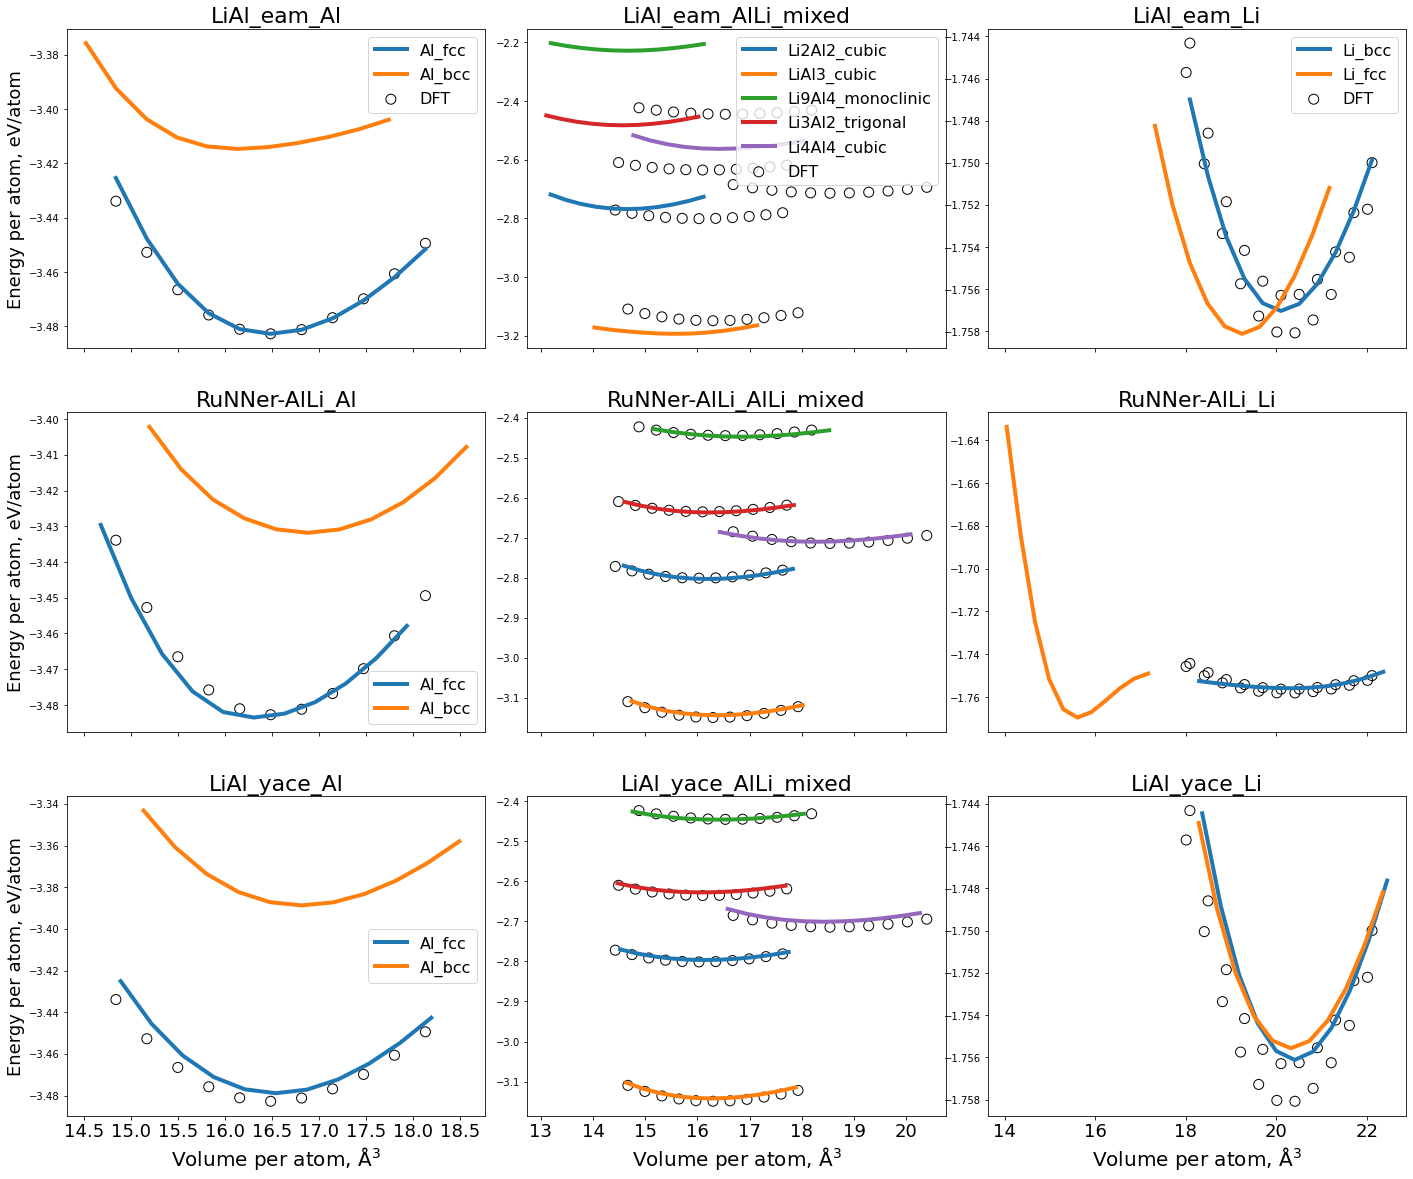

In [32]:
fig, ax_list = plt.subplots(ncols=3, nrows=len(potentials_list), sharex="col")

fig.set_figwidth(24)
fig.set_figheight(20)

color_palette = sns.color_palette("tab10", n_colors=len(data_murn.phase.unique()))


for i, pot in enumerate(potentials_list):
    
    
    mask1 = data_murn["compound"]=="Al"
    data1 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask1)]
    
    mask2 = data_murn["compound"]=="Li"
    data2 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (mask2)]
    
    mask3 = data_murn["compound"].isin(["Al","Li"])
    data3 = data_murn[(data_murn.potential == get_clean_project_name(pot)) & (~mask3)]

    for j,(_, row) in enumerate(data1.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]

        ax_list[i,0].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        
        
        ax_list[i,0].set_title(f"{get_clean_project_name(pot)}" + '_' + data1.iloc[0]["compound"],fontsize=22)
        ax_list[i,0].legend(prop={"size":16})
        
    ax_list[i,0].scatter(al_fcc["vol"],al_fcc["energy"]/al_fcc["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
    for j,(_, row) in enumerate(data2.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]
        
        ax_list[i,2].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        
        
        ax_list[i,2].set_title(f"{get_clean_project_name(pot)}" + '_' + data2.iloc[0]["compound"],fontsize=22)
        # ax_list[i,2].legend(prop={"size":16})
        
    ax_list[i,2].scatter(li["vol"],li["energy"]/li["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
    for j,(_, row) in enumerate(data3.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]
        
        ax_list[i,1].plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"-",
                            lw=4,
                            label= row["phase"], 
                            color=color_palette[j])
        
        ax_list[i,1].set_title(f"{get_clean_project_name(pot)}" + '_AlLi_mixed',fontsize=22)
        # ax_list[i,1].legend(prop={"size":16})
        
    ax_list[i,1].scatter(df_mixed["vol"],df_mixed["energy"]/df_mixed["number_of_atoms"],
                            facecolor="none",edgecolor="k",s=100,label="DFT")
        
        
for i in range(3):
    ax_list[0,i].legend(prop={"size":16})
    ax_list[-1,i].set_xlabel("Volume per atom, $\mathrm{\AA^3}$",fontsize=20)
    ax_list[-1,i].tick_params(axis="x",labelsize=18)
    
for i in range(len(potentials_list)):
    ax_list[i,0].set_ylabel("Energy per atom, eV/atom",fontsize=18)
    
    
    
# ax.legend(prop={"size":16})
# ax.set_ylabel("Energy per atom, eV/atom",fontsize=20)
#break
fig.subplots_adjust(wspace=0.1);

## (b) Elastic constants and Phonons

Pyiron also has job modules to calculate elastic constants and thermal properties using the quasi-harmonic approximation given by the `phonopy` package.

As in the previous task, we again loop over the defined potentials and then over the given structures.

Calculating elastic constants and thermal properties is considerably more expensive than calculating EV curves. Hence, it is useful to only calculate these properties for a subset of most important structures 

In [16]:
list_of_phases = ["Al_fcc","Li_bcc","Li2Al2_cubic","LiAl3_cubic"]

subset_murn = data_murn[data_murn["phase"].isin(list_of_phases)]
subset_murn

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc
11,1283,RuNNer-AlLi,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.211118,20.286595,8.517306,-1.755918,1,Li_bcc
13,1309,RuNNer-AlLi,"(Atom('Li', [4.509081801264686, 2.603319591757272, 1.8408249369278522], index=0), Atom('Li', [6.763622701898693, 3.90497938763465, 2.7612374053913604], index=1), Atom('Al', [-3.844724064520768e-12...",Li2Al2,cubic,6.376805,64.816143,57.934650,-11.212634,4,Li2Al2_cubic
14,1322,RuNNer-AlLi,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0154153406879987, 2.0154153406879987, 2.46817194592603e-16], index=1), Atom('Al', [2.0154153406879987, 1.234085972963015e-16, 2.015415340687998...",LiAl3,cubic,5.700455,65.403086,59.308440,-12.574696,4,LiAl3_cubic
18,1393,LiAl_yace,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.044553,16.541594,87.130427,-3.478909,1,Al_fcc
20,1419,LiAl_yace,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.216389,20.403222,15.823747,-1.756104,1,Li_bcc


In [17]:
for pot in potentials_list:
    group_name = get_clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    print(group_name)
    
    for _, row in subset_murn[subset_murn.potential==group_name].iterrows():
        job_id = row["job_id"]
        
        job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{row.compound}_{row.crystal_structure}")
        ref = pr_pot.load(job_id)
        job_ref.structure = ref.structure
        job_ref.potential = pot
        job_ref.calc_minimize()
        
        elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, f"elastic_job_{row.compound}_{row.crystal_structure}")
        elastic_job.input["eps_range"] = 0.05
        elastic_job.run()
        
        
        phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, f"phonopy_job_{row.compound}_{row.crystal_structure}")
        job_ref.calc_static()
        phonopy_job.run()

LiAl_eam


2022-06-08 14:17:48,273 - pyiron_log - WARNING - The job elastic_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:48,454 - pyiron_log - WARNING - The job phonopy_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:48,754 - pyiron_log - WARNING - The job elastic_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:48,922 - pyiron_log - WARNING - The job phonopy_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:49,223 - pyiron_log - WARNING - The job elastic_job_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:49,398 - pyiron_log - WARNING - The job phonopy_job_Li2Al2_cubic is being loa

RuNNer-AlLi


2022-06-08 14:17:50,177 - pyiron_log - WARNING - The job elastic_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:50,342 - pyiron_log - WARNING - The job phonopy_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:50,639 - pyiron_log - WARNING - The job elastic_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:50,802 - pyiron_log - WARNING - The job phonopy_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:51,099 - pyiron_log - WARNING - The job elastic_job_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:51,271 - pyiron_log - WARNING - The job phonopy_job_Li2Al2_cubic is being loa

LiAl_yace


2022-06-08 14:17:52,054 - pyiron_log - WARNING - The job elastic_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:52,218 - pyiron_log - WARNING - The job phonopy_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:52,515 - pyiron_log - WARNING - The job elastic_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:52,680 - pyiron_log - WARNING - The job phonopy_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:52,983 - pyiron_log - WARNING - The job elastic_job_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-06-08 14:17:53,159 - pyiron_log - WARNING - The job phonopy_job_Li2Al2_cubic is being loa

In [18]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [19]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic["phase"] = data_elastic.compound + "_" + data_elastic.crystal_structure
data_elastic = data_elastic[data_elastic["phase"].isin(list_of_phases)]
data_elastic

The job table_elastic was saved and received the ID: 1780


Loading and filtering jobs:   0%|          | 0/12 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/12 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure,phase
0,1524,LiAl_eam,120.339279,66.483631,45.515458,Al,fcc,Al_fcc
1,1540,LiAl_eam,16.740018,11.018163,12.688217,Li,bcc,Li_bcc
2,1556,LiAl_eam,179.464635,54.231219,47.889040,Li2Al2,cubic,Li2Al2_cubic
3,1573,LiAl_eam,65.443987,47.601166,28.002138,LiAl3,cubic,LiAl3_cubic
4,1590,RuNNer-AlLi,119.613688,59.261331,57.671025,Al,fcc,Al_fcc
5,1606,RuNNer-AlLi,13.974565,4.476591,13.293350,Li,bcc,Li_bcc
6,1622,RuNNer-AlLi,124.404880,20.665379,42.673693,Li2Al2,cubic,Li2Al2_cubic
7,1639,RuNNer-AlLi,88.575923,50.190830,48.202184,LiAl3,cubic,LiAl3_cubic
8,1685,LiAl_yace,133.807535,62.693651,40.423203,Al,fcc,Al_fcc
9,1701,LiAl_yace,18.307762,13.775557,12.106574,Li,bcc,Li_bcc


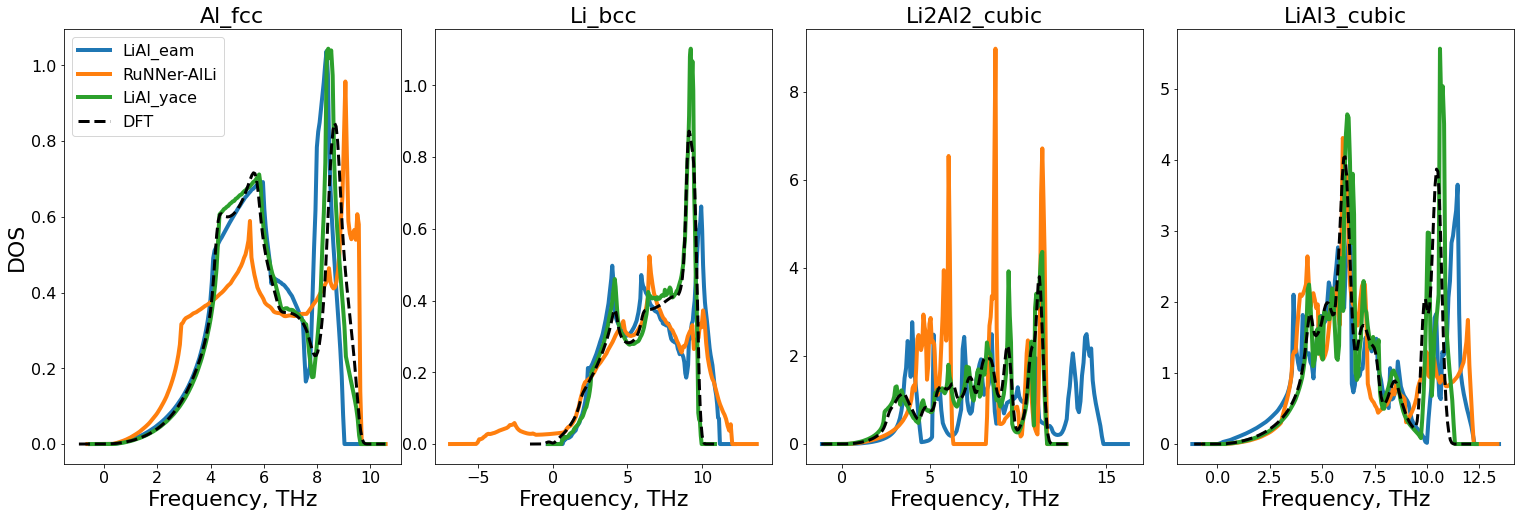

In [20]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1,)

fig.set_figwidth(26)
fig.set_figheight(8)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))

pot = "LiAl_yace"


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    # data = data_elastic[(data_elastic.phase == phase) & (data_elastic["potential"]=="pot")]
    data = data_elastic[(data_elastic.phase == phase)]
    
    # DFT data is read from csv files
    dft_ref = pd.read_csv(phase.lower()+"_dos.csv")
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
        
        
        
        ax.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
                lw=4,
                color=color_palette[j], 
                label=get_clean_project_name(pot))
        
       
        
        ax.set_xlabel("Frequency, THz",fontsize=22)
        
    ax.plot(dft_ref["dos_energy"],dft_ref["dos_total"],ls="--",lw=3,color="k",label="DFT")
        
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("DOS",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

In [21]:
# fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=len(potentials_list), sharey="row")

# fig.set_figwidth(25)
# fig.set_figheight(12)

# color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


# for i, phase in enumerate(data_elastic.phase.unique()):
    
    
#     data = data_elastic[data_elastic.phase == phase]
    
    
    
#     for j, pot in enumerate(potentials_list):
#         ax = ax_list[j][i]
#         phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
#         phonopy_job.plot_band_structure(axis=ax)
#         ax.set_ylabel("")
#         ax.set_title(get_clean_project_name(pot)+"__"+phase,fontsize=18)
#         ax_list[j][0].set_ylabel("DOS")
#     # ax_list[0][i].set_title(f"{phase}")
# fig.subplots_adjust(wspace=0.1, hspace=0.4);

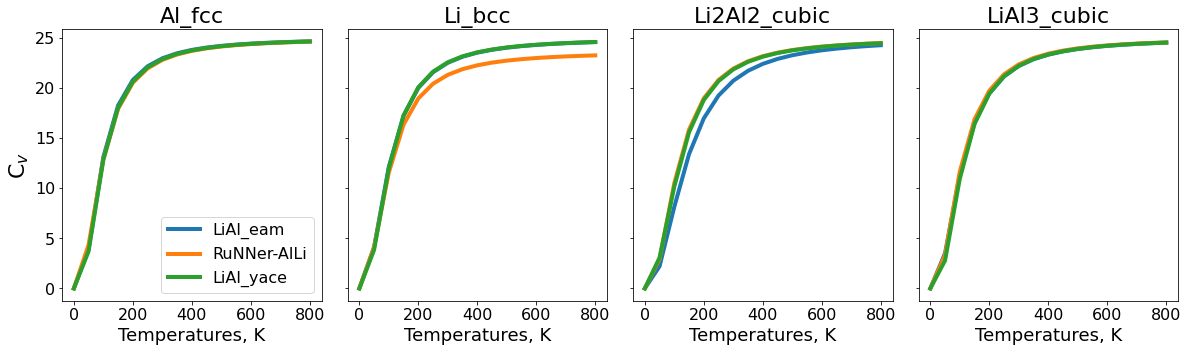

In [22]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    data = data_elastic[data_elastic.phase == phase]
    
    n_atom = data_murn[data_murn["phase"]==phase]["n_atoms"].iloc[0]
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)

        ax.plot(thermo.temperatures, thermo.cv/n_atom,
                lw=4,
                label=get_clean_project_name(pot), 
                color=color_palette[j])
        ax.set_xlabel("Temperatures, K",fontsize=18)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("C$_v$",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

In [23]:
# phonopy_job.plot_band_structure()

## (c) Convex hull

To assess the stability of the binary phases, we plot a convex hull for the considered phases. 

For this task we compute the formation energies of the mixed phases relative to ground state energies of equilibrium unary phases.

In [24]:
from collections import Counter

# pot = "LiAl_yace"

# data_convexhull = data_murn[data_murn["potential"]==pot]
data_convexhull = data_murn.copy()
data_convexhull.head(2)

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc


Using `Collections.counter` we construct a composition dictionary for all the phases and from that dictionary, we can extract the relative concentrations of Al and Li in each structure

Obtain the equilibrium energies for unary Al and Li phases from the Dataframe

Calculate the relative formation energies by subtracting the total energies of the mixed phases with the energies of eq Al and Li

$$E^{A_xB_y}_{f} = E_{A_xB_y} - (x E_A + yE_B)$$

Similarly calculate the formation energies from DFT ref data

In [25]:
def get_e_form(data_convexhull):
    data_convexhull["comp_dict"] = data_convexhull["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
    data_convexhull["n_Al"] = data_convexhull["comp_dict"].map(lambda d: d.get("Al",0))
    data_convexhull["n_Li"] = data_convexhull["comp_dict"].map(lambda d: d.get("Li",0))

    data_convexhull["cAl"]= data_convexhull["n_Al"]/data_convexhull["n_atoms"] * 100
    data_convexhull["cLi"]= data_convexhull["n_Li"]/data_convexhull["n_atoms"] * 100

    E_f_Al = data_convexhull.loc[data_convexhull["n_Li"]==0,"eq_energy"].min()
    E_f_Li = data_convexhull.loc[data_convexhull["n_Al"]==0,"eq_energy"].min()

    data_convexhull["E_form"]=(data_convexhull["eq_energy"])-(data_convexhull[["n_Al","n_Li"]].values * [E_f_Al, E_f_Li]).sum(axis=1)
    data_convexhull["E_form_per_atom"] = data_convexhull["E_form"]/data_convexhull["n_atoms"] * 1e3

    data_convexhull = data_convexhull.sort_values("cLi")

    return data_convexhull

df_eam = get_e_form(data_murn[data_murn["potential"]=="LiAl_eam"].copy())
df_nnp = get_e_form(data_murn[data_murn["potential"]=="RuNNer-AlLi"].copy())
df_ace = get_e_form(data_murn[data_murn["potential"]=="LiAl_yace"].copy())

data_convexhull = pd.concat([df_eam,df_nnp,df_ace])
data_convexhull

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase,comp_dict,n_Al,n_Li,cAl,cLi,E_form,E_form_per_atom
0,1140,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc,{'Al': 1},1,0,100.000000,0.000000,0.000000,0.000000
1,1153,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc,{'Al': 1},1,0,100.000000,0.000000,0.067785,67.785186
5,1205,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic,"{'Li': 1, 'Al': 3}",3,1,75.000000,25.000000,-0.567192,-141.797976
4,1192,LiAl_eam,"(Atom('Li', [4.359978178265943, 2.5172345748814795, 1.7799536377360747], index=0), Atom('Li', [6.53996726740165, 3.775851862320358, 2.669930456604317], index=1), Atom('Al', [-3.964456982410852e-12...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic,"{'Li': 2, 'Al': 2}",2,2,50.000000,50.000000,-0.591954,-147.988453
8,1244,LiAl_eam,"(Atom('Li', [2.142967147985671, 1.2372426587287435, 7.662120717536293], index=0), Atom('Li', [-8.783761113500244e-10, 2.4744853189563414, 0.5913679335098909], index=1), Atom('Li', [-8.783761113500...",Li4Al4,cubic,6.061226,131.389799,71.221355,-20.506570,8,Li4Al4_cubic,"{'Li': 4, 'Al': 4}",4,4,50.000000,50.000000,0.458247,57.280860
7,1231,LiAl_eam,"(Atom('Al', [2.1548001975659234, 1.244075358781918, 1.861784175000869], index=0), Atom('Al', [-2.154798282819334, 3.732223313213554, 2.6646760238080542], index=1), Atom('Li', [8.560563403365654e-0...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal,"{'Al': 2, 'Li': 3}",2,3,40.000000,60.000000,-0.173341,-34.668107
6,1218,LiAl_eam,"(Atom('Li', [4.9874611628416465, 1.0099045365192156, 0.8188840806477526], index=0), Atom('Li', [3.1237816780987666, 1.455730745331952, 2.673723152073369], index=1), Atom('Li', [-3.4421956688209843...",Li9Al4,monoclinic,13.023701,190.504374,53.125276,-28.970054,13,Li9Al4_monoclinic,"{'Li': 9, 'Al': 4}",4,9,30.769231,69.230769,0.785300,60.407664
2,1166,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc,{'Li': 1},0,1,0.000000,100.000000,0.001096,1.096047
3,1179,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc,{'Li': 1},0,1,0.000000,100.000000,0.000000,0.000000
9,1257,RuNNer-AlLi,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.025259,16.355737,76.669339,-3.484016,1,Al_fcc,{'Al': 1},1,0,100.000000,0.000000,0.000000,0.000000


Read df which contains DFT ref data for plotting

In [26]:
convex_ref = pd.read_pickle("dft_convexhull_ref.pckl")
convex_ref

,name,energy,vol,compound,ao,number_of_atoms,comp_dict,n_Al,n_Li,cAl,cLi,E_form,E_form_per_atom
438,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Al_fcc/murn/strain_1_0/data.json,-13.930995,16.484415,Al_fcc,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 2.019983601551115, 2.019983601551115], index=1), Atom('Al', [2.019983601551115, 0.0, 2.019983601551115], index=2), Atom('Al', [2.01998360155...",4,{'Al': 4},4,0,100.000000,0.000000,0.000000,0.000000
910,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl3_mp-10890/murn/strain_1_0/data.json,-12.597018,16.295840,LiAl3_mp-10890,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [2.0122514573524146, 2.0122514573524146, 0.0], index=1), Atom('Al', [2.0122514573524146, 0.0, 2.0122514573524146], index=2), Atom('Al', [0.0, 2.01...",4,"{'Li': 1, 'Al': 3}",3,1,75.000000,25.000000,-0.392474,-98.118408
1950,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl_mp-1067/murn/strain_1_0/data.json,-11.204795,16.028228,LiAl_mp-1067,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Li', [2.246243529971499, 1.2968693066945, 0.9170250810763773], index=1), Atom('Al', [4.492487059942998, 2.593738613389, 1.8340501621527545], index=2), ...",4,"{'Li': 2, 'Al': 2}",2,2,50.000000,50.000000,-0.726701,-181.675339
1275,/home/users/lysogy36/tools/VASP/Al-Li/DFT/LiAl_mp-1079240/murn/strain_1_0/data.json,-21.715330,18.537039,LiAl_mp-1079240,"(Atom('Li', [-2.093764484173552e-06, 2.574581270471953, 3.588630766943668], index=0), Atom('Li', [2.229653899294873, 1.2872887040708958, 5.022609593138096], index=1), Atom('Li', [2.229653899294873...",8,"{'Li': 4, 'Al': 4}",4,4,50.000000,50.000000,-0.759143,-94.892853
652,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li3Al2_mp-16506/murn/strain_1_0/data.json,-13.176984,16.098544,Li3Al2_mp-16506,"(Atom('Li', [7.387307289355338, 3.3557842846492325, 2.205190367378745], index=0), Atom('Li', [4.984874333407062, 2.2644466100798333, 1.488038392346624], index=1), Atom('Li', [0.0, 0.0, 0.0], index...",5,"{'Li': 3, 'Al': 2}",2,3,40.000000,60.000000,-0.942593,-188.518538
231,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li9Al4_mp-568404/murn/strain_1_0/data.json,-31.786765,16.532577,Li9Al4_mp-568404,"(Atom('Li', [15.085585487572331, 3.6087478779487228, 4.372653838370371], index=0), Atom('Li', [13.209884188064274, 3.160045831227256, 2.4668794892606694], index=1), Atom('Li', [6.31626414433567, 1...",13,"{'Li': 9, 'Al': 4}",4,9,30.769231,69.230769,-2.049089,-157.622253
1343,/home/users/lysogy36/tools/VASP/Al-Li/DFT/Li_bcc/murn/strain_1_0/data.json,-3.512596,20.099126,Li_bcc,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Li', [1.712796338409787, 1.712796338409787, 1.712796338409787], index=1))",2,{'Li': 2},0,2,0.000000,100.000000,0.000000,0.000000


Define a function to automatically get the mathematical convex hull

In [27]:
from scipy.spatial import ConvexHull,convex_hull_plot_2d

def get_convexhull(df):
    df_tmp = df.reset_index()

    points = np.zeros([len(df_tmp["cLi"]),2])

    for i,row in df_tmp.iterrows():
        points[i,0], points[i,1] =  float(row["cLi"]), float(row["E_form_per_atom"])

    hull = ConvexHull(points)
    return hull,points

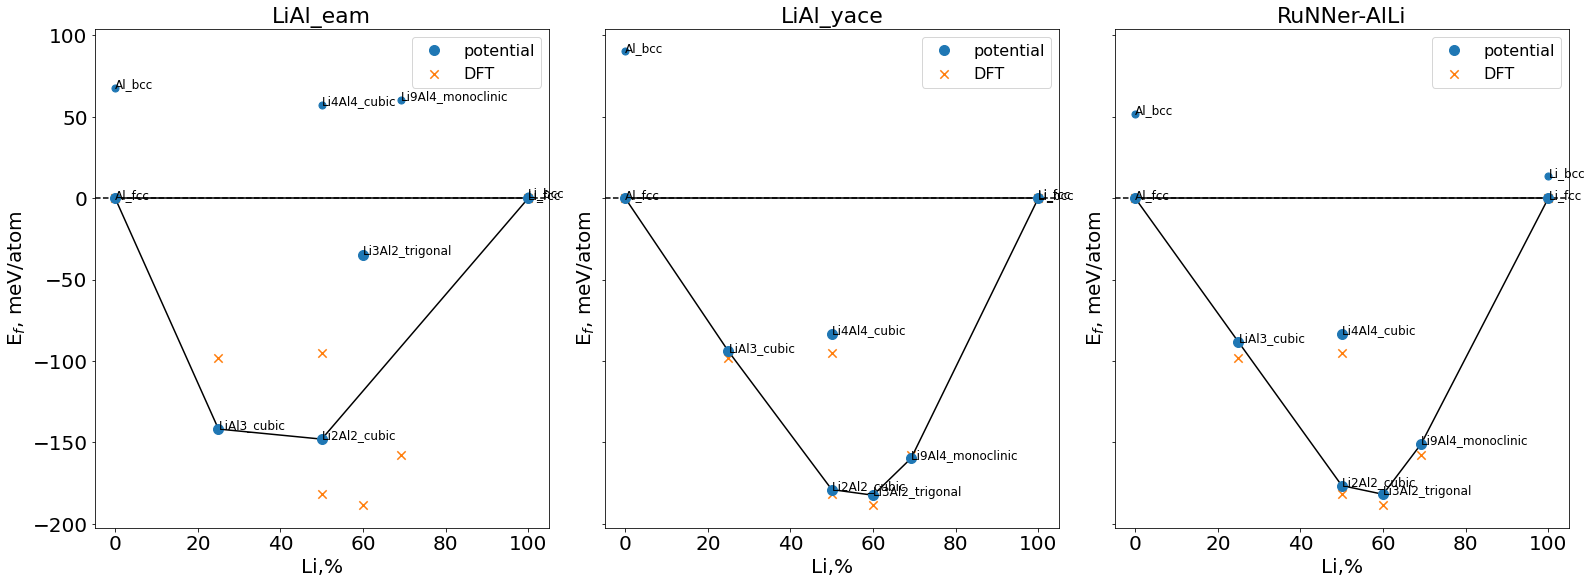

In [30]:
fig,ax = plt.subplots(figsize=(22,8),ncols=len(potentials_list),constrained_layout=True,sharey="row")

dfs = ([pd.DataFrame(y) for x, y in data_convexhull.groupby(by='potential', as_index=False)])

for i,pot in enumerate(potentials_list):
    
    df_tmp = dfs[i].copy()
    
    
    
    ax[i].scatter(df_tmp["cLi"],df_tmp["E_form_per_atom"],marker="o",s=50)
    
    
    df_tmp = df_tmp[(df_tmp["E_form_per_atom"]<0.1) & (df_tmp["E_form"]<0.1)]
    hull,points = get_convexhull(df_tmp)
    
    for simplex in hull.simplices:
        ax[i].plot(points[simplex, 0], points[simplex, 1], 'k-')
    
    
    ax[i].axhline(0,ls="--",color="k")
    ax[i].plot(df_tmp["cLi"], df_tmp["E_form_per_atom"],"o",markersize=10,label="potential")
    ax[i].scatter(convex_ref["cLi"],convex_ref["E_form_per_atom"],marker="x",s=70,
                  label="DFT")
    ax[i].legend(prop={"size":16})
    ax[i].set_xlabel("Li,%",fontsize="20")
    ax[i].set_ylabel("E$_f$, meV/atom",fontsize="20")
    ax[i].tick_params(labelsize=20,axis="both")
# ax.set_ylim(-200,10)
    for _,row in dfs[i].iterrows():
        ax[i].text((row["cLi"]+0.01),row["E_form_per_atom"],row["phase"],size=12)
        
    ax[i].set_title(dfs[i].iloc[0]["potential"],fontsize=22)

plt.show()

In [29]:
time_stop = time.time()
print(f"Total run time for the notebook {time_stop - time_start} seconds")

Total run time for the notebook 180.9642095565796 seconds


In [ ]:
572.1296255588531/60